In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

# Add the 'surv_mcmc' directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from db_utils.eda_dataset_model import MusicService
from data_processing.DataFitting import SurvivalModelTester
import warnings

warnings.filterwarnings("ignore",
                        message="Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples.*")
warnings.filterwarnings("ignore",
                        message="The effect of Potentials on other parameters is ignored during prior predictive sampling.*")
warnings.filterwarnings("ignore",
                        message=" The effect of Potentials on other parameters is ignored during prior predictive sampling.*")
warnings.filterwarnings("ignore",
                        message="rcParams['plot.max_subplots']*")

plt.tight_layout()
# Suppress specific UserWarnings related to tight_layout
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


<Figure size 640x480 with 0 Axes>

In [3]:
music_data = MusicService().get_music_data()

File snowflake_eda_tracks.csv loaded successfully
File snowflake_eda_tracks_playlists_302.csv loaded successfully
File snowflake_eda_tracks_discovery_302.csv loaded successfully


In [4]:
service = MusicService()
df = service.get_merged_data2(music_data)

In [5]:
# Prepare the data
age = df['age'].values
total_streams = df['streams'].values

In [6]:
df

,age,isrc,direct,high,low,mid,recommendation,num_playlists,streams,proportion_direct,...,total_discovery_streams,avg_inverse_length,avg_inverse_age,first_month_incomplete,censored,proportion_discovery,track_low,track_middle,track_popular,track_star
0,1,USUYG1366780,42401,18085,1186,4543,9646,2.0,75863.0,0.558915,...,27667.0,0.008268,0.009829,1.0,0,0.364697,True,False,False,False
1,1,USUYG1374061,89576,16298,1370,4512,66204,3.0,177963.0,0.503341,...,63610.0,0.008711,0.005304,0.0,0,0.357434,True,False,False,False
2,1,USUYG1374631,59144,177560,172,1770,4998,4.0,243648.0,0.242744,...,128728.0,0.009692,0.008807,1.0,0,0.528336,False,True,False,False
3,1,USUYG1374662,383549,14306,637,208,34821,3.0,433524.0,0.884724,...,90661.0,0.007017,0.008232,0.0,0,0.209126,False,False,True,False
4,1,USUYG1374820,159814,79560,2036,10936,7661,3.0,260010.0,0.614646,...,81692.0,0.007695,0.009775,1.0,0,0.314188,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,31,USUYG1414617,44422,27,355,283,2383,1.0,47471.0,0.935771,...,6725.0,0.008057,0.012236,0.0,1,0.141665,True,False,False,False
10993,31,USUYG1415980,52637,55,1189,810,3463,1.0,58155.0,0.905116,...,4564.0,0.008056,0.009295,0.0,1,0.078480,False,True,False,False
10994,31,USUYG1415981,88540,11,1375,1709,9699,1.0,101335.0,0.873736,...,11100.0,0.010989,0.008611,0.0,1,0.109538,False,True,False,False
10995,31,USUYG1415984,351103,6202,8310,5779,41984,4.0,413382.0,0.849343,...,18645.0,0.008228,0.011357,0.0,1,0.045104,False,False,True,False


# Data distribution and transformation

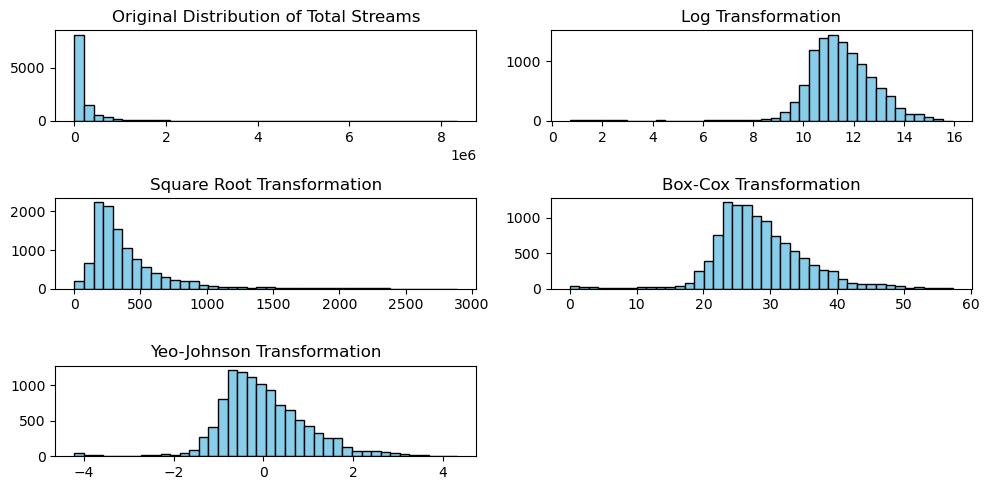

In [7]:
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

# Original Distribution
plt.figure(figsize=(10, 5))

plt.subplot(3, 2, 1)
plt.hist(total_streams, bins=40, color='skyblue', edgecolor='black')
plt.title('Original Distribution of Total Streams')

# 1. Log Transformation (adding 1 to avoid log(0))
log_total_streams = np.log(total_streams + 1)
plt.subplot(3, 2, 2)
plt.hist(log_total_streams, bins=40, color='skyblue', edgecolor='black')
plt.title('Log Transformation')

# 2. Square Root Transformation
sqrt_total_streams = np.sqrt(total_streams)
plt.subplot(3, 2, 3)
plt.hist(sqrt_total_streams, bins=40, color='skyblue', edgecolor='black')
plt.title('Square Root Transformation')

# 3. Box-Cox Transformation (requires positive data)
# Adding a small constant to ensure data is positive (if needed)
boxcox_total_streams, _ = stats.boxcox(total_streams + 1e-6)  # Small value added for safety
plt.subplot(3, 2, 4)
plt.hist(boxcox_total_streams, bins=40, color='skyblue', edgecolor='black')
plt.title('Box-Cox Transformation')

# 4. Yeo-Johnson Transformation (can handle non-positive values)
power_transformer = PowerTransformer(method='yeo-johnson')
yeojohnson_total_streams = power_transformer.fit_transform(total_streams.reshape(-1, 1)).flatten()
plt.subplot(3, 2, 5)
plt.hist(yeojohnson_total_streams, bins=40, color='skyblue', edgecolor='black')
plt.title('Yeo-Johnson Transformation')

plt.tight_layout()
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
logistic,0.043129,1177.838172,-136882.256913,inf,0.038692,9.669671e-15
dweibull,0.056727,1094.535400,-133859.364793,inf,0.043281,2.445839e-18
burr,0.058189,1103.201491,-133570.175733,inf,0.044841,1.184227e-19
norm,0.101901,1542.444700,-127427.042787,inf,0.088732,8.688874e-76
exponnorm,0.101902,1544.441004,-127417.661187,inf,0.088733,8.673449e-76


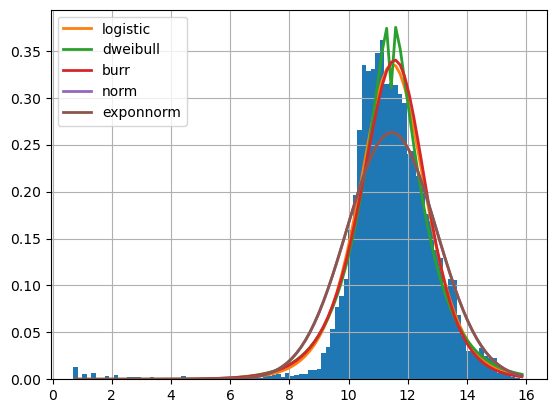

In [8]:
from fitter import Fitter

# Use Fitter to fit the data
f = Fitter(log_total_streams, distributions=['gamma',
                                             'lognorm',
                                             'skewnorm',
                                             'dweibull',
                                             'expon',
                                             'exponpow',
                                             #'exponweib',
                                             'exponnorm',
                                             'invgamma',
                                             'loggamma',
                                             'logistic',
                                             'loglaplace',
                                             'powerlognorm',
                                             #"beta",
                                             'betaprime',
                                             "burr",
                                             'gumbel_l',
                                             "norm",
                                             "halfnorm"])
f.fit()

# Display the summary with the best fitting distribution
f.summary()

In [9]:
censored = df['censored'].values.astype(bool)
observed_data = log_total_streams[~censored]
censored_data = log_total_streams[censored]
observed_age = age[~censored]
censored_age = age[censored]
# Separate observed data into uncensored and censored portions
uncensored_idx = np.where(~censored)[0]
censored_idx = np.where(censored)[0]
f.get_best(method='sumsquare_error')

{'logistic': {'loc': 11.47951545117588, 'scale': 0.7440650315035606}}

In [10]:
import statsmodels.api as sm

X = df['age']
y = np.log(df['streams'])

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Extract the estimated parameters
mu_alpha_prior = model.params['const']
mu_beta_prior = model.params['age']
mu_alpha_sd = model.bse['const']
mu_beta_sd = model.bse['age']

print(f"Estimated mu_alpha: {mu_alpha_prior}, SD: {mu_alpha_sd}")
print(f"Estimated mu_beta: {mu_beta_prior}, SD: {mu_beta_sd}")

Estimated mu_alpha: 11.908816234719584, SD: 0.02928947312007293
Estimated mu_beta: -0.024244480064617935, SD: 0.0013559619263274433


# Growth model without covariates

In [18]:
import pymc as pm

# Build the hierarchical model with logistic likelihood and custom censoring
with pm.Model() as model:
    # Informative priors based on linear regression estimates
    mu_alpha = pm.Normal('mu_alpha', mu=mu_alpha_prior, sigma=0.5)
    mu_beta = pm.Normal('mu_beta', mu=mu_beta_prior, sigma=0.1)

    # Priors for the individual (isrc-level) intercepts and slopes
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=1)
    beta = pm.Normal('beta', mu=mu_beta, sigma=1)

    # Expected value
    mu = alpha + beta * age

    # Priors for logistic parameters
    #loc = pm.Normal('loc', mu=12.53, sigma=1)
    scale = pm.HalfNormal('scale', sigma=1)

    # Likelihood for uncensored data
    pm.Logistic('observed', mu=mu[~censored], s=scale, observed=observed_data)

    # Custom likelihood for censored data using Potential
    # Cumulative probability up to the censoring threshold
    logistic_cdf = pm.math.sigmoid((censored_data - mu[censored]) / scale)
    pm.Potential('censored_likelihood', pm.math.log(1 - logistic_cdf).sum())

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Output()

In [19]:
# Summary of the posterior
summary = az.summary(trace, var_names=['mu_alpha', 'mu_beta', 'alpha', 'beta', 'scale'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,11.904,0.450,11.103,12.796,0.005,0.003,8688.0,5467.0,1.0
mu_beta,-0.024,0.097,-0.205,0.161,0.001,0.001,10667.0,5623.0,1.0
alpha,11.846,0.024,11.801,11.891,0.000,0.000,5808.0,5587.0,1.0
beta,-0.019,0.001,-0.021,-0.016,0.000,0.000,6028.0,5738.0,1.0
scale,0.732,0.006,0.721,0.743,0.000,0.000,10127.0,6119.0,1.0


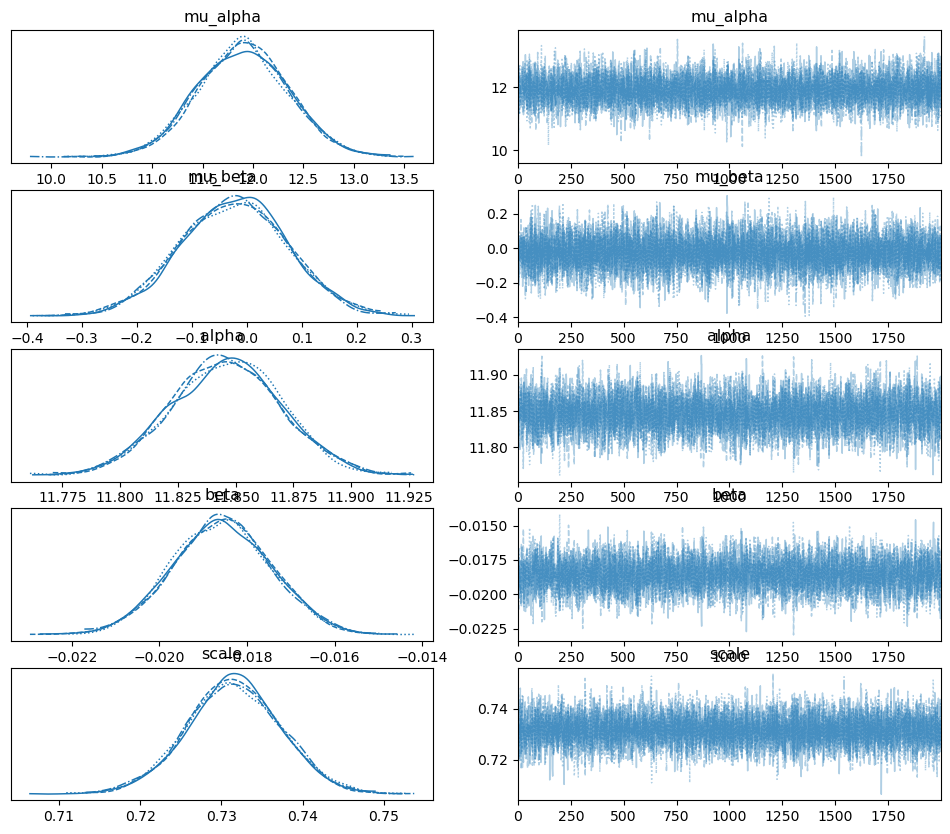

In [21]:
# Plot the traces
az.plot_trace(trace, var_names=['mu_alpha', 'mu_beta', 'alpha', 'beta', 'scale'])
plt.show()

In [22]:
# Posterior predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace)
# Plot the posterior predictive checks
az.plot_ppc(ppc)
plt.show()

Output()

C:\Users\runet\AppData\Local\Temp\ipykernel_36296\3678625769.py:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace)


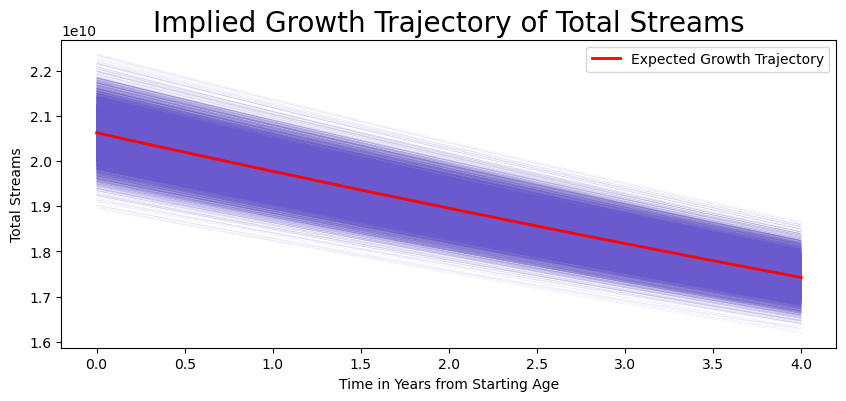

In [25]:
import xarray as xr

# Assuming `trace` is the InferenceData object from PyMC sampling, containing posterior samples
posterior = az.extract(trace)

# Extract group-level intercepts and slopes
# Using `mu_alpha` and `mu_beta` as global intercept and slope
# `alpha` and `beta` represent subject-specific deviations
global_intercept = posterior["mu_alpha"].mean().values
global_slope = posterior["mu_beta"].mean().values
intercept_group_specific = posterior["alpha"].values  # Individual intercepts
slope_group_specific = posterior["beta"].values  # Individual slopes

# Calculate overall intercept (a) and slope (b) for each individual
a = global_intercept + intercept_group_specific
b = global_slope + slope_group_specific

# Time points for plotting the growth trajectory
time_xi = np.linspace(0, 4, 100)  # For a smooth curve from age 0 to age 4

# Plotting the individual trajectories and the overall growth trajectory
fig, ax = plt.subplots(figsize=(10, 4))

# Convert from log scale back to original scale using exponentiation
for ai, bi in zip(a, b):
    ax.plot(time_xi, np.exp(ai + bi * time_xi), color="slateblue", alpha=0.2, linewidth=0.2)

# Plot overall expected growth trajectory
overall_a = a.mean()
overall_b = b.mean()
ax.plot(time_xi, np.exp(overall_a + overall_b * time_xi), color="red", lw=2, label="Expected Growth Trajectory")

# Set labels, title, and legend
ax.set_ylabel("Total Streams")
ax.set_xlabel("Time in Years from Starting Age")
ax.legend()
ax.set_title("Implied Growth Trajectory of Total Streams", fontsize=20)
plt.show()

In [11]:
proportions = df[
    ['proportion_direct', 'proportion_high', 'proportion_low', 'proportion_mid', 'proportion_recommendation',
     'proportion_discovery']].values

# Growth model with initial discovery effect

In [12]:
influence_period_df = df[df['age'] <= 3]  # Influence period: ages 14 to 16
avg_discovery_influence = influence_period_df.groupby('isrc')['proportion_discovery'].mean()
growth_period_df = df[df['age'] > 3]
# Map `avg_discovery_influence` back to the longitudinal data for the growth period
# Create a new column in the growth_period_df that matches each individual with their average influence
growth_period_df = growth_period_df.copy()
growth_period_df['avg_discovery_influence'] = growth_period_df['isrc'].map(avg_discovery_influence)
id_indx, unique_ids = pd.factorize(growth_period_df["isrc"])
coords = {"ids": unique_ids, "obs": range(len(growth_period_df))}
censored = growth_period_df['censored'].values.astype(bool)
log_total_streams = np.log(growth_period_df['streams'].values + 1)
observed_data = log_total_streams[~censored]
censored_data = log_total_streams[censored]

In [45]:
import pymc as pm

with pm.Model(coords=coords) as model:
    age = pm.Data("age", growth_period_df["age"].values)  # Use data only for growth period
    avg_discovery_influence_data = pm.Data("avg_discovery_influence",
                                           growth_period_df['avg_discovery_influence'].values)
    #proportion_direct = pm.Data("proportion_direct", df["proportion_direct"].values)
    # proportion_high = pm.Data("proportion_high", df["proportion_high"].values)
    # proportion_low = pm.Data("proportion_low", df["proportion_low"].values)
    # proportion_mid = pm.Data("proportion_mid", df["proportion_mid"].values)
    # proportion_recommendation = pm.Data("proportion_recommendation", df["proportion_recommendation"].values)
    # proportion_discovery = pm.Data("proportion_discovery", df["proportion_discovery"].values)
    # Informative priors based on linear regression estimates
    global_intercept = pm.Normal('global_intercept', mu=mu_alpha_prior, sigma=0.5)
    global_slope = pm.Normal('global_slope', mu=mu_beta_prior, sigma=0.1)
    #global_age_beta = pm.Normal("global_age_beta", 0, 1)

    # Priors for the individual (isrc-level) intercepts and slopes
    subject_intercept_sigma = pm.HalfNormal('subject_intercept_sigma', 5)
    subject_slope_sigma = pm.HalfNormal('subject_slope_sigma', 5)
    # Priors for the individual (isrc-level) intercepts and slopes
    subject_intercept = pm.Normal('subject_intercept', mu=global_intercept, sigma=subject_intercept_sigma, dims="ids")
    subject_slope = pm.Normal('subject_slope', mu=global_slope, sigma=subject_slope_sigma, dims="ids")

    # Coefficient for the average discovery influence effect
    beta_discovery_influence = pm.Normal('beta_discovery_influence', mu=0, sigma=0.5)
    # Global coefficients for the proportions
    #beta_direct = pm.Normal('beta_direct', mu=0, sigma=1)
    # beta_high = pm.Normal('beta_high', mu=0, sigma=1)
    # beta_low = pm.Normal('beta_low', mu=0, sigma=1)
    # beta_mid = pm.Normal('beta_mid', mu=0, sigma=1)
    # beta_recommendation = pm.Normal('beta_recommendation', mu=0, sigma=1)
    # beta_discovery = pm.Normal('beta_discovery', mu=0, sigma=1)
    # Growth model as a deterministic variable
    growth_model = pm.Deterministic(
        "growth_model",
        subject_intercept[id_indx] +
        subject_slope[id_indx] * age +
        beta_discovery_influence * avg_discovery_influence_data * age  # Effect from the first 2 month
        #(global_slope + subject_slope[id_indx])  # +
        #beta_direct * proportion_direct  # +
        # beta_high * proportion_high +
        # beta_low * proportion_low +
        # beta_mid * proportion_mid +
        # beta_recommendation * proportion_recommendation +
        # beta_discovery * proportion_discovery
    )

    # Priors for logistic parameters
    scale = pm.HalfNormal('scale', sigma=1)

    # Likelihood for uncensored data
    pm.Logistic('observed', mu=growth_model[~censored], s=scale, observed=observed_data)

    # Custom likelihood for censored data using Potential
    # Cumulative probability up to the censoring threshold
    logistic_cdf = pm.math.sigmoid((censored_data - growth_model[censored]) / scale)
    pm.Potential('censored_likelihood', pm.math.log(1 - logistic_cdf).sum())

    # Sample from the posterior
    trace = pm.sample(1000,chains=2, tune=500, init="jitter+adapt_diag", target_accept=0.95, return_inferencedata=True)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [46]:
# Summary of the posterior
summary = az.summary(trace,
                     var_names=['global_intercept', 'global_slope', 'subject_intercept_sigma', 'subject_slope_sigma',
                                'beta_discovery_influence'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_intercept,11.989,0.073,11.850,12.123,0.001,0.001,2509.0,1531.0,1.00
global_slope,0.011,0.012,-0.012,0.032,0.006,0.004,5.0,22.0,1.33
subject_intercept_sigma,1.330,0.057,1.228,1.437,0.001,0.001,2134.0,1710.0,1.00
subject_slope_sigma,0.070,0.003,0.064,0.075,0.000,0.000,2346.0,1365.0,1.00
beta_discovery_influence,-0.137,0.043,-0.210,-0.057,0.020,0.015,4.0,28.0,1.40


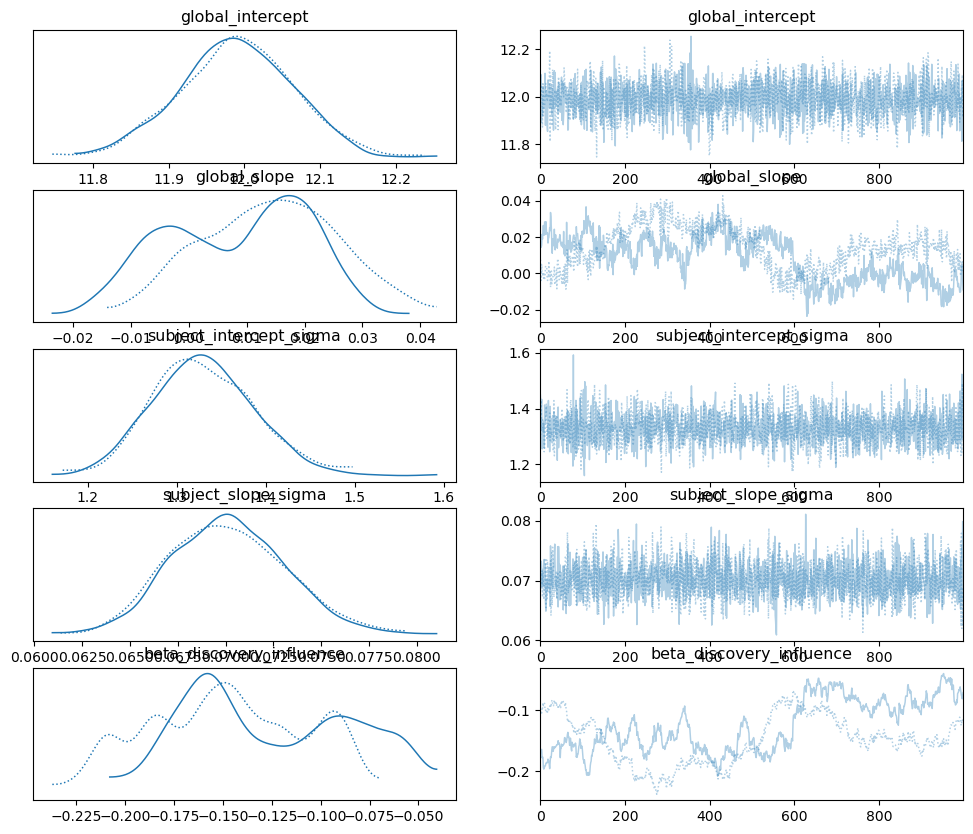

In [47]:
# Plot the traces
az.plot_trace(trace, var_names=['global_intercept', 'global_slope', 'subject_intercept_sigma', 'subject_slope_sigma',
                                'beta_discovery_influence'])
plt.show()

Output()

C:\Users\runet\AppData\Local\Temp\ipykernel_648\442749081.py:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace)


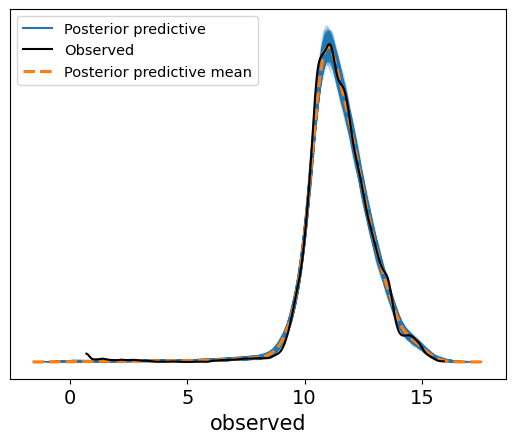

In [48]:
# Posterior predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace)
# Plot the posterior predictive checks
az.plot_ppc(ppc)
plt.show()

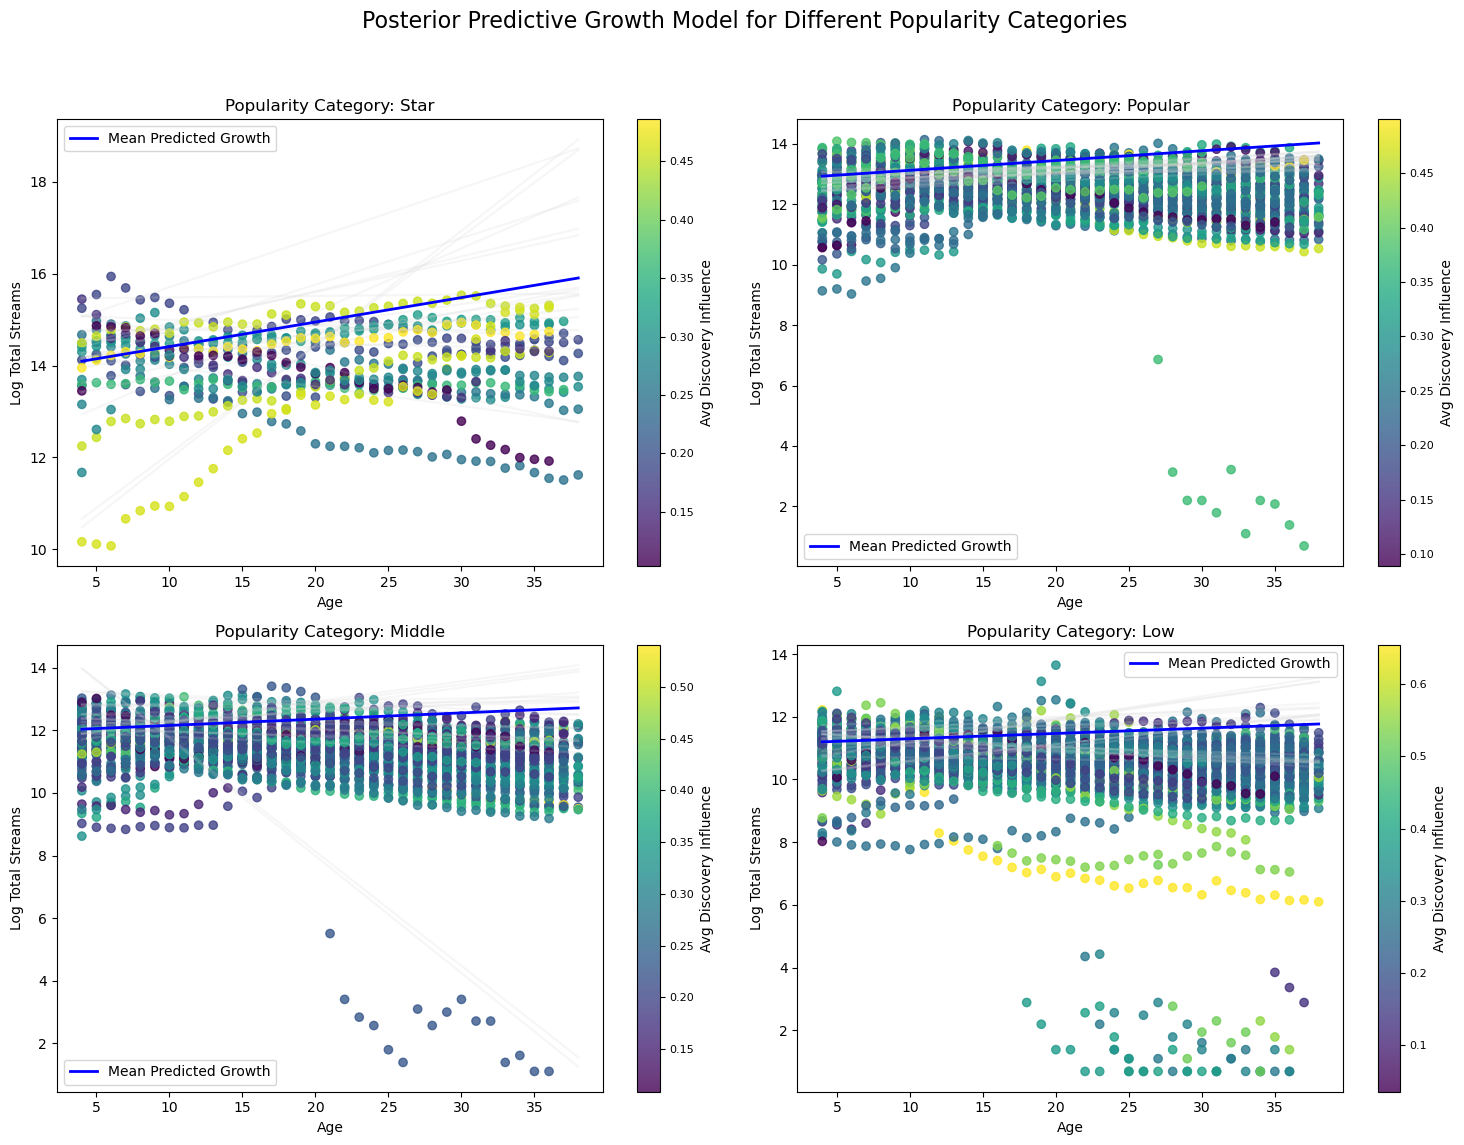

In [49]:
def get_popularity_category(row):
    if row['track_star']:
        return 'star'
    elif row['track_popular']:
        return 'popular'
    elif row['track_middle']:
        return 'middle'
    elif row['track_low']:
        return 'low'
growth_period_df['popularity_category'] = growth_period_df.apply(get_popularity_category, axis=1)

# Define the popularity categories
popularity_categories = ['star', 'popular', 'middle', 'low']

# Prepare ages for predictions
ages = np.linspace(growth_period_df['age'].min(), growth_period_df['age'].max(), 100)

# Set up the plotting environment
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

# Loop over each popularity category and generate a plot
for idx, category in enumerate(popularity_categories):
    ax = axs[idx]

    # Filter data for the current category
    category_df = growth_period_df[growth_period_df['popularity_category'] == category]
    
    # If there's no data for the category, skip it
    if category_df.empty:
        ax.set_title(f"No data for category '{category}'")
        continue

    # Prepare data for the current category
    avg_discovery_mean = category_df['avg_discovery_influence'].mean()
    log_total_streams = np.log(category_df['streams'].values + 1)
    avg_discovery_influence_array = category_df['avg_discovery_influence'].values

    # Extract posterior samples specifically for the current category
    intercept_samples = trace.posterior['subject_intercept'].sel(ids=category_df['isrc'].unique()).values.flatten()
    slope_samples = trace.posterior['subject_slope'].sel(ids=category_df['isrc'].unique()).values.flatten()
    discovery_samples = trace.posterior['beta_discovery_influence'].values.flatten()

    # Generate predictions for each sample and age specifically for the current category
    predicted_values = [
        intercept + slope * ages + discovery * avg_discovery_mean
        for intercept, slope, discovery in zip(intercept_samples, slope_samples, discovery_samples)
    ]

    # Calculate the mean prediction specifically for the current category
    mean_prediction = np.mean(predicted_values, axis=0)

    # Plot the predictions for the current category
    for sample in predicted_values[::100]:  # Plot a subset of predictions for visual clarity
        ax.plot(ages, sample, color='lightgray', alpha=0.2)

    ax.plot(ages, mean_prediction, color='blue', linewidth=2, label='Mean Predicted Growth')
    scatter = ax.scatter(category_df['age'], log_total_streams, c=avg_discovery_influence_array, cmap='viridis', alpha=0.8)

    ax.set_title(f"Popularity Category: {category.capitalize()}")
    ax.set_xlabel('Age')
    ax.set_ylabel('Log Total Streams')
    ax.legend()

    # Add a color bar to represent `avg_discovery_influence` for each individual plot
    cbar = fig.colorbar(scatter, ax=ax, label='Avg Discovery Influence', orientation='vertical')
    cbar.ax.tick_params(labelsize=8)

# Set the overall title
plt.suptitle("Posterior Predictive Growth Model for Different Popularity Categories", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
